# Helper functions

In [16]:
from helper_utils import word_wrap, load_chroma

# Retrieving

In [4]:
from PyPDF2 import PdfReader

reader = PdfReader("microsoft_annual_report_2022.pdf")

pdf_texts = [p.extract_text().strip() for p in reader.pages]

# Filter the empty strings
pdf_texts = [t for t in pdf_texts if t]

print(word_wrap(pdf_texts[0]))

1 Dear shareholders, colleagues, customers, and partners:  
We are
living through a period of historic economic, societal, and
geopolitical change. The world in 2022 looks nothing like 
the world in
2019. As I write this, inflation is at a 40 -year high, supply chains
are stretched, and the war in Ukraine is 
ongoing. At the same time, we
are entering a technological era with the potential to power awesome
advancements 
across every sector of our economy and society. As the
world’s largest software company, this places us at a historic

intersection of opportunity and responsibility to the world around us.
 
Our mission to empower every person and every organization on the
planet to achieve more has never been more 
urgent or more necessary.
For all the uncertainty in the world, one thing is clear: People and
organizations in every 
industry are increasingly looking to digital
technology to overcome today’s challenges and emerge stronger. And no

company is better positioned to help th

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

character_splitter = RecursiveCharacterTextSplitter(
            separators=["\n\n", "\n", " ", "", ". "],
            chunk_size=1000,
            chunk_overlap=0)

character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

In [6]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0,
    tokens_per_chunk=256
)
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

print(word_wrap(token_split_texts[0]))
print(f"\nTotal tokens: {len(token_split_texts)}")

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


1 dear shareholders, colleagues, customers, and partners : we are
living through a period of historic economic, societal, and
geopolitical change. the world in 2022 looks nothing like the world in
2019. as i write this, inflation is at a 40 - year high, supply chains
are stretched, and the war in ukraine is ongoing. at the same time, we
are entering a technological era with the potential to power awesome
advancements across every sector of our economy and society. as the
world ’ s largest software company, this places us at a historic
intersection of opportunity and responsibility to the world around us.
our mission to empower every person and every organization on the
planet to achieve more has never been more urgent or more necessary.
for all the uncertainty in the world, one thing is clear : people and
organizations in every industry are increasingly looking to digital
technology to overcome today ’ s challenges and emerge stronger. and no

Total tokens: 349


In [7]:
import chromadb

from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_client = chromadb.Client()

chroma_collection = chroma_client.create_collection("microsoft-annual-report-2022", embedding_function=embedding_function)

ids = [str(i) for i in range(len(token_split_texts))]

chroma_collection.add(
    ids=ids,
    documents=token_split_texts
)

chroma_collection.count()


349

In [8]:
query = "What was the total revenue"

results = chroma_collection.query(query_texts=[query], n_results=5)

retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(word_wrap(document))
    print("\n---\n")

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

---

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in m

In [13]:
from dotenv import load_dotenv

load_dotenv()
import os
import openai

from openai import OpenAI

openai_client = OpenAI()

In [14]:
def rag(query, retrieved_documents, model="gpt-4o-mini"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [15]:
output = rag(query=query, retrieved_documents=retrieved_documents)

print(word_wrap(output))

The total revenue for the year ended June 30, 2022, was $198,270
million.


# Pitfall of retrievals

In [21]:
from helper_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [24]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']

umap_transform = umap.UMAP(random_state=42, transform_seed=42).fit(embeddings)





/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   

In [26]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

100%|██████████| 349/349 [00:01<00:00, 258.59it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

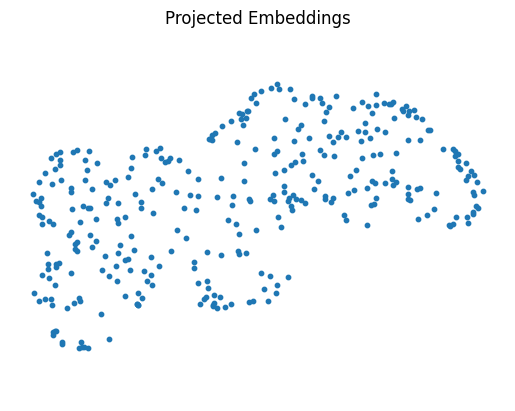

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

## Relevancy and Distraction

In [28]:
query = "What is the total revenue?"

results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

revenue, classified by significant product and service offerings, was
as follows : ( in millions ) year ended june 30, 2022 2021 2020 server
products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office
products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22,
488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8,
077 search and news advertising 11, 591 9, 267 8, 524 enterprise
services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291
4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast
certain previously reported amounts in the table above to conform to
the way we internally manage and monitor our business.

74 note 13 — unearned revenue unearned revenue by segment was as
follows : ( in millions ) june 30, 2022 2021 productivity and business
processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more
personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in
unearned revenue were as follows : ( in millio

In [29]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 186.11it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

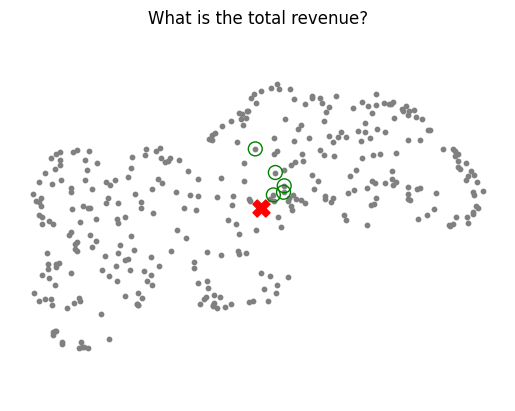

In [30]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [31]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = chroma_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

culture of trust can help navigate the challenges the world faces
today. organizations of all sizes have digitized business - critical
functions, redefining what they can expect from their business
applications. customers are looking to unlock value while simplifying
security and management. from infrastructure and data, to business
applications and collaboration, we provide unique, differentiated value
to customers. we are building a distributed computing fabric – across
cloud and the edge – to help every organization build, run, and manage
mission - critical workloads anywhere. in the next phase of innovation,
artificial intelligence ( “ ai ” ) capabilities are rapidly advancing,
fueled by data and knowledge of the world. we are enabling metaverse
experiences at all layers of our stack, so customers can more
effectively model, automate, simulate, and predict changes within their
industrial

every organization turn its data into predictive and analytical power.
with our new microsoft 

In [32]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 547.75it/s]


(-0.23134116977453234,
 10.70633955448866,
 4.531994795799255,
 10.938042187690735)

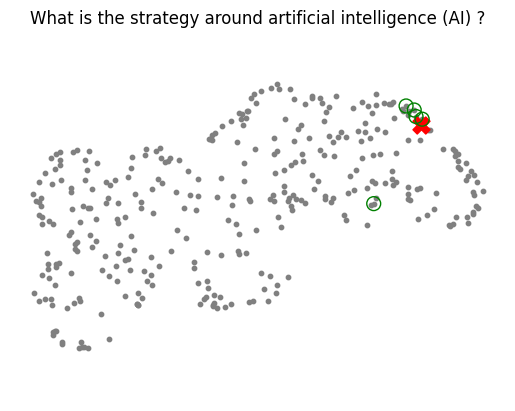

In [33]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

# Query expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


349

In [2]:
import os
import openai
from openai import OpenAI
from dotenv import load_dotenv
import umap

load_dotenv()

openai_client = OpenAI()



embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 349/349 [00:01<00:00, 289.35it/s]


In [3]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [4]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? Over the past
fiscal year, we are pleased to report that our executive team has
remained stable with minimal turnover. The CEO, CFO, COO, and other key
executives have continued to provide strong leadership and guidance to
drive the company towards its strategic goals. The continuity in our
executive team has contributed to a consistent and cohesive approach to
our business operations.


In [5]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

88 report of independent registered public accounting firm to the
stockholders and the board of directors of microsoft corporation
opinion on internal control over financial reporting we have audited
the internal control over financial reporting of microsoft corporation
and subsidiaries ( the “ company ” ) as of june 30, 2022, based on
criteria established in internal control — integrated framework ( 2013
) issued by the committee of sponsoring organizations of the treadway
commission ( coso ). in our opinion, the company maintained, in all
material respects, effective internal control over financial reporting
as of june 30, 2022, based on criteria establis hed in internal control
— integrated framework ( 2013 ) issued by coso. we have also audited,
in accordance with the standards of the public company accounting
oversight board ( united states ) ( pcaob ), the consolidated financial
statements as of and for the year ended june 30, 2022, of the company
and

84 report of independent re

In [6]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:00<00:00, 601.54it/s]


(-2.3402276754379274, 8.930132937431335, 5.837422800064087, 11.638551282882691)

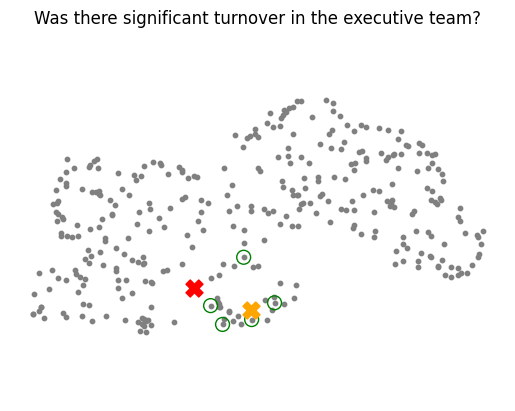

In [7]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## Query Expansion with multiple queries

In [8]:
def augment_multiple_query(query, model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [9]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did the company's revenue compare to the previous year?
- What were the key drivers behind the revenue growth?
- Were there any significant changes in the company's pricing strategy?
- Did the company enter new markets or launch new products/services that impacted revenue?
- How did exchange rates and inflation affect the company's revenue?


In [10]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

In [11]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:00<00:00, 652.83it/s]


In [12]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:00<00:00, 607.09it/s]


(-2.3402276754379274, 8.930132937431335, 5.837422800064087, 11.638551282882691)

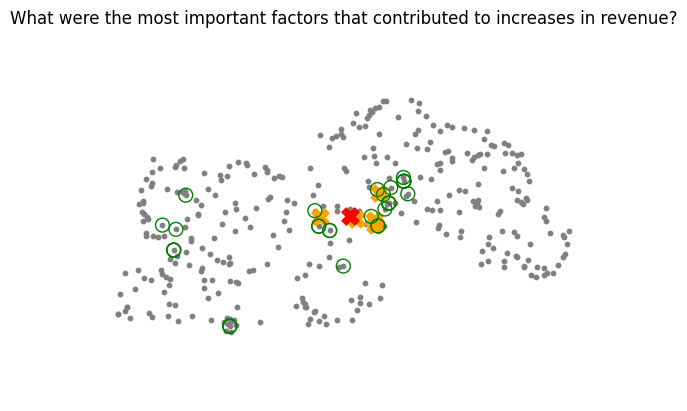

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

# Cross encoder re-ranking

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

query = "What has been the investment in research and development?"
results = chroma_collection.query(query_texts=query, n_results=10, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


• operating expenses increased $ 1. 5 billion or 14 % driven by
investments in gaming, search and news advertising, and windows
marketing. operating expenses research and development ( in millions,
except percentages ) 2022 2021 percentage change research and
development $ 24, 512 $ 20, 716 18 % as a percent of revenue 12 % 12 %
0ppt research and development expenses include payroll, employee
benefits, stock - based compensation expense, and other headcount -
related expenses associated with product development. research and
development expenses also include third - party development and
programming costs, localization costs incurred to translate software
for international markets, and the amortization of purchased software
code and services content. research and development expenses increased
$ 3. 8 billion or 18 % driven by investments in cloud engineering,
gaming, and linkedin. sales and marketing

competitive in local markets and enables us to continue to attract top
talent from ac

In [2]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

pairs = [[query, doc] for doc in retrieved_documents]
scores = cross_encoder.predict(pairs)
print("Scores:")
for score in scores:
    print(score)

Scores:
0.98693454
2.6445785
-0.26803184
-10.731592
-7.706604
-5.646998
-4.2970343
-10.933231
-7.038426
-7.324696


In [3]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o+1)

New Ordering:
2
1
3
7
6
9
10
5
4
8


## Cross-encoder re-ranking with query expansion

In [4]:
original_query = "What were the most important factors that contributed to increases in revenue?"
generated_queries = [
    "What were the major drivers of revenue growth?",
    "Were there any new product launches that contributed to the increase in revenue?",
    "Did any changes in pricing or promotions impact the revenue growth?",
    "What were the key market trends that facilitated the increase in revenue?",
    "Did any acquisitions or partnerships contribute to the revenue growth?"
]

In [5]:
queries = [original_query] + generated_queries

results = chroma_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']

In [6]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

unique_documents = list(unique_documents)

In [7]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [8]:
scores = cross_encoder.predict(pairs)


In [9]:
print("Scores:")
for score in scores:
    print(score)

Scores:
-1.1369964
-6.902091
-10.148886
-10.711213
-9.918428
-8.505106
-10.000137
-5.2747526
-10.042842
-7.404208
-4.3417683
-9.807879
-4.6518893
-9.357723
-9.768024
-4.8184843
-7.7540984
-3.7681518
-11.079269
-3.7948627
-10.0839405
-5.141832
-7.9171762


In [10]:
print("New Ordering:")
for o in np.argsort(scores)[::-1]:
    print(o)

New Ordering:
0
17
19
10
12
15
21
7
1
9
16
22
5
13
14
11
4
6
8
20
2
3
18


# Embedding adapters

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import numpy as np
import umap
from tqdm import tqdm
import torch

/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

349

In [3]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=42, transform_seed=42).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings=embeddings, umap_transform=umap_transform)


/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 349/349 [00:01<00:00, 278.81it/s]


In [4]:
import os
import openai
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()

openai_client = OpenAI()

## Creating dataset

In [5]:
def generate_queries(model="gpt-4o-mini"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
            "Suggest 10 to 15 short questions that are important to ask when analyzing an annual report. "
            "Do not output any compound questions (questions with multiple sentences or conjunctions)."
            "Output each question on a separate line divided by a newline."
        },
    ]
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [7]:
generated_queries = generate_queries()
for query in generated_queries:
    print(query)

What is the company's revenue growth compared to the previous fiscal year?  

How has the company's net income changed over the last year?  

What is the company's gross profit margin and how does it trend over time?  

Are there any significant changes in operating expenses?  

What are the major drivers of revenue for the company?  

How does the company's current ratio compare to industry standards?  

What is the company's debt-to-equity ratio?  

What is the return on equity for the company?  

Are there any notable changes in assets or liabilities?  

How much cash and cash equivalents does the company hold?  

What is the outlook provided by management regarding future performance?  

Are there any ongoing legal or regulatory issues mentioned in the report?  

What dividends are declared and how does it compare to the previous year?  

What investments in research and development are reported?  

How does the company's performance compare to its peers?  


In [16]:
results = chroma_collection.query(
    query_texts=generated_queries, 
    n_results=10, 
    include=['documents', 'embeddings'],
    )
retrieved_documents = results['documents']

In [17]:
def evaluate_results(query, statement, model="gpt-4o-mini"):
    messages = [
    {
        "role": "system",
        "content": "You are a helpful expert financial research assistant. You help users analyze financial statements to better understand companies. "
        "For the given query, evaluate whether the following satement is relevant."
        "Output only 'yes' or 'no'."
    },
    {
        "role": "user",
        "content": f"Query: {query}, Statement: {statement}"
    }
    ]
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        max_tokens=1
    )
    content = response.choices[0].message.content
    if content == "yes":
        return 1
    return -1

In [18]:
retrieved_embeddings = results['embeddings']
query_embeddings = embedding_function(generated_queries)

adapter_query_embeddings = []
adapter_doc_embeddings = []
adapter_labels = []

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        adapter_query_embeddings.append(query_embeddings[q])
        adapter_doc_embeddings.append(retrieved_embeddings[q][d])
        adapter_labels.append(evaluate_results(query, document))

100%|██████████| 29/29 [02:25<00:00,  5.01s/it]


In [19]:
len(adapter_labels)

290

In [20]:
adapter_query_embeddings = torch.Tensor(np.array(adapter_query_embeddings))
adapter_doc_embeddings = torch.Tensor(np.array(adapter_doc_embeddings))
adapter_labels = torch.Tensor(np.expand_dims(np.array(adapter_labels), axis=1))

In [21]:
dataset = torch.utils.data.TensorDataset(adapter_doc_embeddings, adapter_query_embeddings, adapter_labels)

## Setup the model

In [23]:
def model(query_embedding, document_embedding, adaptor_matrix):
    updated_query_embedding = torch.matmul(adaptor_matrix, query_embedding)
    return torch.cosine_similarity(updated_query_embedding, document_embedding, dim=0)

def mse_loss(query_embeddings, document_embedding, adaptor_matrix, label):
    return torch.nn.MSELoss()(model(query_embedding, document_embedding, adaptor_matrix), label)

mat_size = len(adapter_query_embeddings[0])
adapter_matrix = torch.randn(mat_size, mat_size, requires_grad=True)

In [24]:
min_loss = float('inf')
best_matrix = None

for epoch in tqdm(range(100)):
    for query_embedding, document_embedding, label in dataset:
        loss = mse_loss(query_embedding, document_embedding, adapter_matrix, label)
        if loss < min_loss:
            min_loss = loss
            best_matrix = adapter_matrix.clone().detach().numpy()

            loss.backward()
            with torch.no_grad():
                adapter_matrix -= 0.01 * adapter_matrix.grad
                adapter_matrix.grad.zero_()


  0%|          | 0/100 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/llm/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:01<00:00, 73.32it/s]


In [25]:
print(f"Best loss: {min_loss.detach().numpy()}")

Best loss: 0.7762019038200378


In [26]:
test_vector = torch.ones((mat_size, 1))
scaled_vector = np.matmul(best_matrix, test_vector).numpy()

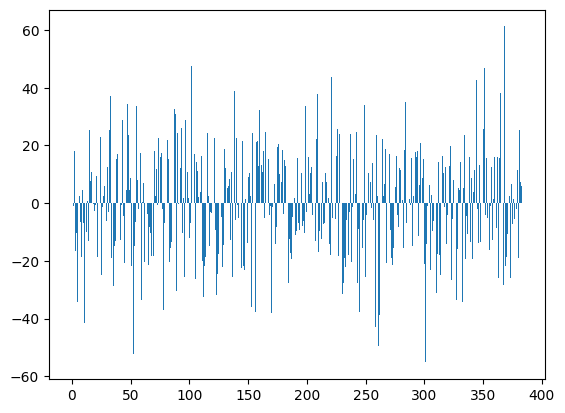

In [27]:
import matplotlib.pyplot as plt
plt.bar(range(len(scaled_vector)), scaled_vector.flatten())
plt.show()

In [28]:
query_embeddings = embedding_function(generated_queries)
adapted_query_embeddings = np.matmul(best_matrix, np.array(query_embeddings).T).T

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 29/29 [00:00<00:00, 240.94it/s]


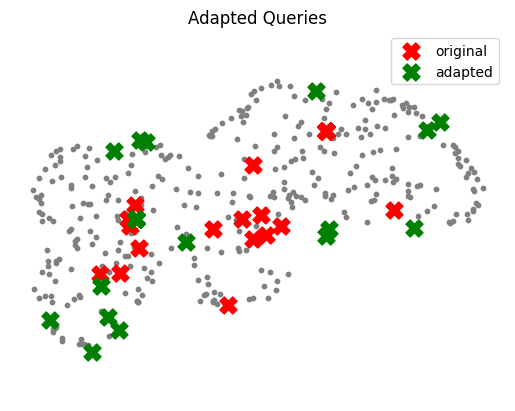

In [29]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embeddings[:, 0], projected_query_embeddings[:, 1], s=150, marker='X', color='r', label="original")
plt.scatter(projected_adapted_query_embeddings[:, 0], projected_adapted_query_embeddings[:, 1], s=150, marker='X', color='green', label="adapted")

plt.gca().set_aspect('equal', 'datalim')
plt.title("Adapted Queries")
plt.axis('off')
plt.legend()